

```
# This is formatted as code
```

# Imports and Seeding

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D
# from google.colab import drive
print('Imports complete.')

Imports complete.


Using TensorFlow backend.


# Mount Google Drive, Read Data

In [2]:
# This will mount your personal drive. Note you'll need to authenticate.
# drive.mount('/content/drive')

In [3]:
# Google doesn't seem to currently support accessing a folder which is shared
# with you. So, I've uploaded 'all_data.csv' to my own drive. To run, you'll
# need to do the same.
# os.listdir('/content/drive/My Drive')
# TODO: Remove row limitation.
# df = pd.read_csv('/content/drive/My Drive/all_data.csv', index_col=0, parse_dates=True,
#                  infer_datetime_format=True) #, nrows=(1/5)*60*24*7*4)
df = pd.read_csv('all_data.csv', index_col=0, parse_dates=True,
                 infer_datetime_format=True)
# Why my 'tz_convert' line did nothing in combine_all_data.py, I don't know.
df.index = pd.to_datetime(df.index, utc=True)
# df.index = df.index.tz_localize('UTC')
df = df.tz_convert('America/New_York')
print('Data loaded.')

Data loaded.


In [4]:
print(df.head())
print(df.tail())
# print(df.info())
# Since our time is evenly spaced, linear interpolation should do.
# Why this didn't take in the script that created the file, I'm not sure.
df.interpolate(method='linear', inplace=True)
# After interpolation, there's just one NaN left. Use forward and backfilling.
df.fillna(method='ffill', inplace=True)
df.fillna(method='backfill', inplace=True)
# Confirm we got rid of all the NaNs.
nan_count = df.isna().sum()
nan_cols = nan_count > 0
print('Columns with NaNs:')
print(df.columns[nan_cols])
print('NaN counts:')
print(nan_count[nan_cols])

                           forecast_lbmp__capitl  forecast_lbmp__centrl  \
Time Stamp                                                                
2016-01-01 00:00:00-05:00                  30.19                  13.04   
2016-01-01 00:05:00-05:00                  30.19                  13.04   
2016-01-01 00:10:00-05:00                  30.19                  13.04   
2016-01-01 00:15:00-05:00                  30.19                  13.04   
2016-01-01 00:20:00-05:00                  30.19                  13.04   

                           forecast_lbmp__dunwod  forecast_lbmp__genese  \
Time Stamp                                                                
2016-01-01 00:00:00-05:00                  25.79                  12.45   
2016-01-01 00:05:00-05:00                  25.79                  12.45   
2016-01-01 00:10:00-05:00                  25.79                  12.45   
2016-01-01 00:15:00-05:00                  25.79                  12.45   
2016-01-01 00:20:00-05:0

Columns with NaNs:
Index([], dtype='object')
NaN counts:
Series([], dtype: int64)


# Shift realtime data ahead by one hour

In [5]:
# We'll predict the lbmp in NYC.
pred_col = 'realtime_lbmp__nyc'

# First, extract the column we'll be making predictions on.
y = df[pred_col].copy(deep=True)

# Loop over the columns.
for c in df.columns:
    # In combine_all_data.py, all realtime data was prefixed with 'realtime_'.
    # When we encounter a realtime column, shift it by 12 spots (1 hour for
    # 5 minute intervals.)
    if c.startswith('realtime_'):
        df[c] = df[c].shift(12)

# After shifting the realtime data ahead, we have NaNs in our first
# 12 rows. Drop them.
df.dropna(inplace=True)

# Drop the same rows in y.
y = y[df.index]

print(y.head())
print(df[pred_col].head())

print('Realtime data shifted.')

# print(df.head())

Time Stamp
2016-01-01 01:00:00-05:00    45.27
2016-01-01 01:05:00-05:00    20.00
2016-01-01 01:10:00-05:00    19.00
2016-01-01 01:15:00-05:00    24.38
2016-01-01 01:20:00-05:00    47.00
Name: realtime_lbmp__nyc, dtype: float64
Time Stamp
2016-01-01 01:00:00-05:00     18.82
2016-01-01 01:05:00-05:00     18.82
2016-01-01 01:10:00-05:00    230.87
2016-01-01 01:15:00-05:00     54.19
2016-01-01 01:20:00-05:00     38.38
Name: realtime_lbmp__nyc, dtype: float64
Realtime data shifted.


# Split Data Into Testing vs. Training, Extract Feature We'll be Predicting

In [6]:
# Let's look at realtime LBMP in NYC.
# No need to drop features since we extracted 'y' before shifting all the realtime data.
x = df

# TODO: We probably shouldn't be using real-time data in training/predicting,
# right? This should maybe be a two-step process: Predict 5-minute real-time 
# (will need another network/model to do that), then plug that in for LMP
# training/predicting.
y_train = y['2016':'2017']
y_test = y['2018']
x_train = x['2016':'2017']
x_test = x['2018']

print('Data split for train vs. test.')

Data split for train vs. test.


# Scale Data

In [7]:
# We'll use "standard" scaling
# Scale y data.
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# 
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train.values)
x_test_scaled = scaler_x.transform(x_test.values)
print('Data has been scaled.')

# Ensure we have no NaNs.
np.isnan(x_train_scaled).any()

Data has been scaled.


False

# Use Lasso to determine important features

In [26]:
lasso = LassoCV(cv=5, max_iter=100000, n_jobs=-1, fit_intercept=False)
lasso.fit(x_train_scaled, y_train_scaled.ravel())
print('Alpha: {}'.format(lasso.alpha_))
# print('Coefficients:')
# print(lin_reg.coef_)
non_zero = lasso.coef_ != 0.0
print('Number of non-zero coefficients: {}'.format((non_zero).sum()))
print('Features:')
features_lasso = df.columns.values[non_zero]
print(features_lasso)

Alpha: 0.0185282626201218
Number of non-zero coefficients: 17
Features:
['forecast_lbmp__dunwod' 'forecast_lbmp__longil' 'forecast_lbmp__nyc'
 'forecast_marginal_cost_losses__capitl'
 'forecast_marginal_cost_losses__pjm' 'realtime_lbmp__capitl'
 'realtime_lbmp__longil' 'realtime_lbmp__mhkvl' 'realtime_lbmp__nyc'
 'realtime_marginal_cost_losses__genese'
 'realtime_marginal_cost_losses__hq'
 'realtime_marginal_cost_losses__north'
 'realtime_marginal_cost_losses__oh'
 'realtime_marginal_cost_congestion__genese' 'realtime_load_millwd'
 'relativehumidity_a' 'windspeed_i']


Coefficients:
[ 0.14141797  0.11684023  0.04218273 -0.00608498  0.02870531  0.07185611
  0.01284545  0.05005215  0.15520194 -0.0932728   0.04767164  0.02384489
  0.12302205  0.11821404  0.05503059  0.03510136 -0.02610469]


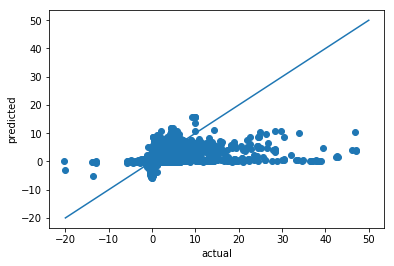

In [27]:
# Perform a simple linear regression with the non-zero lasso coefficients.
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(x_train_scaled[:, non_zero], y_train_scaled.ravel())
print('Coefficients:')
print(lin_reg.coef_)
y_pred = lin_reg.predict(x_test_scaled[:, non_zero])

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

# Use Random Forest to determine important features

In [10]:
# Create RandomForest classifier
rf = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1, max_depth=5)
rf.fit(x_train_scaled, np.ravel(y_train_scaled))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [28]:
# Display the top features.
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# print feature importances in descending order
for f in range(15):
    print("{}. feature {} ({})".format(f + 1, df.columns[indices[f]],
                                       importances[indices[f]]))
    
# Grab as many features as we got from Lasso.
features_rf = df.columns.values[indices[0:len(features_lasso)]]

1. feature realtime_lbmp__nyc (0.31944670762563726)
2. feature forecast_load_hudvl (0.0819301909422377)
3. feature forecast_marginal_cost_congestion__genese (0.0575987499581216)
4. feature forecast_marginal_cost_congestion__west (0.05575933184538576)
5. feature windspeed_a (0.03722046470257008)
6. feature forecast_lbmp__pjm (0.033809567547731685)
7. feature realtime_marginal_cost_congestion__genese (0.025215015490983247)
8. feature realtime_load_capitl (0.022402914494415498)
9. feature realtime_load_mhkvl (0.022093780969636802)
10. feature realtime_marginal_cost_congestion__west (0.02056977216322739)
11. feature forecast_lbmp__nyc (0.018000854699389415)
12. feature relativehumidity_i (0.01756932489174653)
13. feature realtime_lbmp__longil (0.014965980501072942)
14. feature realtime_marginal_cost_losses__genese (0.011072572564060886)
15. feature realtime_marginal_cost_losses__west (0.01010272188004681)


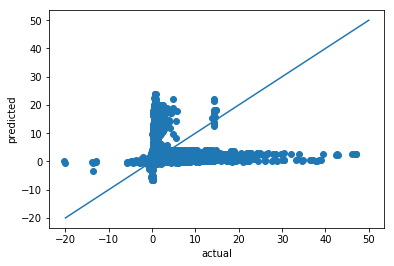

In [29]:
y_pred = rf.predict(x_test_scaled)

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

# Compare Lasso and RandomForest features

In [42]:
common_features = set(features_lasso) & set(features_rf)
print('{} common features from Lasso and RandomForest:'.format(len(common_features)))
print(common_features)

# Let's grab the top 10 RF features and the top 10 Lasso features and create the intersection.
# Start by creating a dictionary of Lasso features.
for ind, col in enumerate(features_lasso):
    lasso_dict[col] = abs(lin_reg.coef_[ind])
    
# Sort.
lasso_top_ten = sorted(lasso_dict.items(), key=lambda kv: kv[1], reverse=True)
lasso_top_ten = [x[0] for x in lasso_top_ten[0:10]]

print('')
print('Top ten features for Lasso and RandomForest:')
top_ten_df = pd.DataFrame({'Lasso': lasso_top_ten, 'RandomForest': features_rf[0:10]})
print(top_ten_df)

# Take the union of the top ten features for both models.
features_to_use = list(set(lasso_top_ten) | set(features_rf[0:10]))
# print('')
# print('Union of top ten Lasso and top ten RF features ({} features):'.format(len(features_to_use)))
# print(features_to_use)

# Get the indices of these features in the original DataFrame.
col_list = list(df.columns.values)
feature_indices = [col_list.index(x) for x in features_to_use]

# Check.
print('Expected features:')
print(features_to_use)
print('Feautures reference by index:')
print(list(df.columns.values[feature_indices]))

5 common features from Lasso and RandomForest:
{'realtime_lbmp__nyc', 'forecast_lbmp__nyc', 'realtime_lbmp__longil', 'realtime_marginal_cost_losses__genese', 'realtime_marginal_cost_congestion__genese'}

Top ten features for Lasso and RandomForest:
                                       Lasso  \
0                         realtime_lbmp__nyc   
1                      forecast_lbmp__dunwod   
2          realtime_marginal_cost_losses__oh   
3  realtime_marginal_cost_congestion__genese   
4                      forecast_lbmp__longil   
5      realtime_marginal_cost_losses__genese   
6                      realtime_lbmp__capitl   
7                       realtime_load_millwd   
8                       realtime_lbmp__mhkvl   
9          realtime_marginal_cost_losses__hq   

                                RandomForest  
0                         realtime_lbmp__nyc  
1                        forecast_load_hudvl  
2  forecast_marginal_cost_congestion__genese  
3    forecast_marginal_cost_conges

# Extract most important features

In [43]:
# Note that we're directly modifying our scaled arrays.
x_train_scaled = x_train_scaled[:, feature_indices]
x_test_scaled = x_test_scaled[:, feature_indices]
print(x_train_scaled.shape)

(210516, 18)


# Create and Train Simple ANN

In [48]:
# This is just a silly simple ANN. Neurons per layer were selected with barely
# any thought (except that people tend to use numbers which are powers of 2).
ann = Sequential()
ann.add(Dense(x_train_scaled.shape[1], input_dim=x_train_scaled.shape[1], activation='relu'))
ann.add(Dense(256, activation='relu'))
ann.add(Dropout(0.25))
ann.add(Dense(128, activation='relu'))
ann.add(Dropout(0.25))
ann.add(Dense(64, activation='relu'))
ann.add(Dropout(0.25))
ann.add(Dense(1))

# TODO: Optimizer? Not getting good results with adadelta or adam.
ann.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['mse'])

ann.summary()
print(x_train_scaled.shape)

# Create early stopping callback.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform the fit. We'll shuffle the data after each epoch, and withhold 
# 20% of the data for validation.
ann.fit(x_train_scaled, y_train_scaled, epochs=100, shuffle=True,
        validation_split=0.2, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

# Predict with ANN

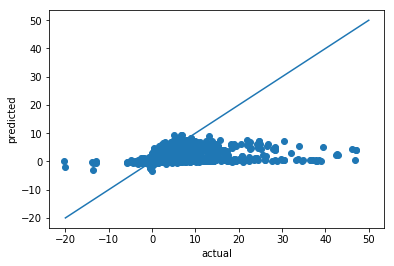

In [49]:
y_pred = ann.predict(x_test_scaled)

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

# Get relevant constants for reshaping data

In [50]:
# How many weeks are we using for batches?
num_weeks = 4

# How many full weeks do we have?
five_min_per_week = int((1/5) * 60 * 24 * 7)
# Given the shape of our data, how many weeks are there? (round down)
weeks_train = np.floor(x_train_scaled.shape[0] / five_min_per_week).astype(int)
weeks_test = np.floor(x_test_scaled.shape[0] / five_min_per_week).astype(int)
# Given how many weeks we have and assuming we train with 4 week batches, how
# many batches will we have?
batches_train = int(np.floor(weeks_train) / num_weeks)
batches_test = int(np.floor(weeks_test) / num_weeks)
# Determine the ending index of the data we'll keep (trim off the end)
keep_train = five_min_per_week * batches_train
keep_test = five_min_per_week * batches_test
# Number of timesteps in a "month"
t_per_m = five_min_per_week * num_weeks
# Num features for convenience.
num_f = x_train_scaled.shape[1]

# Reshape data for 1D CNN

In [51]:
x_1d_train = np.zeros((batches_train, t_per_m, num_f))
y_1d_train = np.zeros((batches_train, t_per_m))

x_1d_test = np.zeros((batches_test, t_per_m, num_f))
y_1d_test = np.zeros((batches_test, t_per_m))

# Loop and put each month into the correct spot.
for b in range(x_1d_train.shape[0]):
    # Determine starting and ending index:
    start_idx = int(b * t_per_m)
    end_idx = start_idx + t_per_m

    # Drop the data in.
    x_1d_train[b, :, :] = x_train_scaled[start_idx:end_idx, :]
    #     y_1d_train[b] = y_train_scaled[end_idx]
    y_1d_train[b, :] = y_train_scaled[start_idx:end_idx, :].ravel()
    
        # Repeat for the testing data. However, we'll bail if we get an index error.
    try:
      x_1d_test[b, :, :] = x_test_scaled[start_idx:end_idx, :]
      y_1d_test[b, :] = y_test_scaled[start_idx:end_idx, :].ravel()
      
    except IndexError:
      pass

print('Data reshaped for 1D CNN')

Data reshaped for 1D CNN


# To start, try a "simple" 1D CNN

In [ ]:
# Benefit to the 1D CNN: We don't have to reshape our data in a complicated manner
# Cons: TBD

# TODO: Finish this up. Ran out of time :/ 
# In the section below (Reshape Data for 2D CNN) there are some useful 
# constants, etc. We may need to do some simple data reshaping for this 1D CNN,
# like arranging the data into batches. Take a look at what was done for the 
# section below. Note that here, we would likely just have to group the data
# into 4-week batches to pass in for convolution. To be honest, I'm not really
# sure how this 1D convolution works though.

# # https://keras.io/layers/convolutional/
cnn1d = Sequential()
# Kernel size of 36 - 3 hours of 5 minute windows?
cnn1d.add(Conv1D(filters=8, kernel_size=6, padding='same',
                 input_shape=(t_per_m, num_f)))
cnn1d.add(Flatten())
cnn1d.add(Dense(512, activation='relu'))
cnn1d.add(Dense(t_per_m))
          
cnn1d.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

cnn1d.summary()

cnn1d.fit(x_1d_train, y_1d_train, epochs=10)

In [ ]:
y_pred = cnn1d.predict(x_1d_test)

# TODO: Move this import - inline imports are poor form.
plt.scatter(y_1d_test.flatten(), y_pred.flatten())
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

# Reshape Data for 2D CNN

In [ ]:
# TODO: revisit this and get it working. 2D convolutional would be quite 
# interesting.

# # How many full weeks do we have?
# five_min_per_week = int((1/5) * 60 * 24 * 7)
# # Given the shape of our data, how many weeks are there? (round down)
# weeks_train = np.floor(x_train_scaled.shape[0] / five_min_per_week).astype(int)
# weeks_test = np.floor(x_test_scaled.shape[0] / five_min_per_week).astype(int)
# # Given how many weeks we have and assuming we train with 4 week batches, how
# # many batches will we have?
# batches_train = int(np.floor(weeks_train) / 4)
# batches_test = int(np.floor(weeks_test) / 4)
# # Determine the ending index of the data we'll keep (trim off the end)
# keep_train = five_min_per_week * batches_train
# keep_test = five_min_per_week * batches_test

# # Trim the training and testing data.

# x_train_scaled_keep = x_train_scaled[0:keep_train, :]
# print('Trimmed traning data shape:')
# print(x_train_scaled_keep.shape)
# y_train_scaled_keep = y_train_scaled[0:keep_train]
# print(y_train_scaled_keep.shape)

# x_test_scaled_keep = x_test_scaled[0:keep_test, :]
# y_test_scaled_keep = y_test_scaled[0:keep_test]
# print(x_test_scaled_keep.shape)
# print(y_test_scaled_keep.shape)

# # Reshape the data!
# # Arrange the data so that we have (batch, height, width, channels). We'll first
# # try with one "month" batches, so we'll have "batches_train" or "batches_test"
# # of them. Each "month" is 4 weeks (the height) and has 2016 samples
# #(five_min_per_week). Finally, we'll have a channel for each feature.
# x_train_reshaped = np.zeros((batches_train, 4, five_min_per_week,
#                              x_train_scaled_keep.shape[1]))
# x_test_reshaped = np.zeros((batches_test, 4, five_min_per_week,
#                             x_test_scaled_keep.shape[1]))
# # TODO: how do we need to reshape the y's? Array of vectors? Row per "month"?

# # Time steps per 4 week month:
# t_per_m = five_min_per_week * 4

# # Loop over the features
# for f_idx in range(x_train_reshaped.shape[-1]):
#   # Loop over the "months".
#   for m_idx in range(batches_train):
#     # Determine starting and ending index:
#     start_idx = int(m_idx * t_per_m)
#     end_idx = start_idx + t_per_m
    
#     # Extract the relevant portions of the training data.
#     d_train = x_train_scaled_keep[start_idx:end_idx, f_idx]
    
#     # Reshape the training data.
#     d_train_reshaped = np.reshape(d_train, newshape=(4, five_min_per_week))
    
#     # Place the data into the reshaped array.
#     x_train_reshaped[m_idx, :, :, f_idx] = d_reshaped
    
#     # Repeat for the testing data. However, we'll bail if we get an index error.
#     try:
#       d_test = x_test_scaled_keep[start_idx:end_idx, f_idx]
      
#     except IndexError:
#       pass
#     else:
#       try:
#         d_test_reshaped = np.reshape(d_test, newshape=(4, five_min_per_week))
#         x_test_reshaped[m_idx, :, :, f_idx] = d_test_reshaped
#       except ValueError as e:
#         print('m_idx: {}, f_idx: {}'.format(m_idx, f_idx))
#         print('start_idx: {}, end_idx: {}'.format(start_idx, end_idx))
#         print('Shape of x_test_scaled_keep: {}'.format(x_test_scaled_keep.shape))
#         raise e
    
# print('Data reshaped.')

# Create 2D CNN

In [ ]:
# TODO: This was left in an incomplete state.

# # If training is taking too long, we may want to switch to 'SeperableConv2D'
# # layers instead of simply Conv2D
# model = Sequential()
# # kernel size of 12, 4 will give us 12 5 minutes intervals and 4 weeks if the 
# # data is arranged in a weekly format.
# # 
# # Using strides of 3, 1 so we traverse 15 minutes of data at a time.
# model.add(Conv2D(filters=8, kernel_size=(12, 4), strides=(3, 1),
#                  padding='same', data_format='channels_last',
#                  input_shape=(4, five_min_per_week, x_train.shape[1])))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='relu'))

# model.compile(loss=keras.losses.mean_squared_error, optimizer='Adam',
#               metrics=['accuracy'])
# print(model.summary())

# Train CNN

In [ ]:
# model.fit()